In [1]:

import numpy as np
import pandas as pd
import eli5

from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.linear_model import SGDClassifier
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

import datetime
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

In [2]:
train_df = pd.read_csv(r'D:\Загрузки\train_sessions.csv\train_sessions.csv', index_col='session_id')
#D:\Загрузки\train_sessions.csv\train_sessions.csv     из красного 
# C:\Users\ILYA\Downloads\train_sessions.csv (1)\train_sessions.csv    из серого

In [3]:
test_df = pd.read_csv(r'D:\Загрузки\test_sessions.csv\test_sessions.csv', index_col='session_id')
# D:\Загрузки\test_sessions.csv\test_sessions.csv   из красного 
# C:\Users\ILYA\Downloads\test_sessions.csv (1)\test_sessions.csv из серого 

In [4]:
# В обучающей выборке train_sessions.csv:

# Признаки site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl)
# Признаки time_j – время посещения сайтов site_j
# Целевой признак target – факт того, что сессия принадлежит Элис (то есть что именно Элис ходила по всем этим сайтам)

In [5]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [6]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [7]:
train_df.target.value_counts()

0    251264
1      2297
Name: target, dtype: int64

In [8]:
train_df.query('target==1')

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
153,5397,2013-11-22 13:23:49,5395.0,2013-11-22 13:23:49,22.0,2013-11-22 13:23:50,5396.0,2013-11-22 13:23:50,5402.0,2013-11-22 13:23:50,...,2013-11-22 13:23:50,22.0,2013-11-22 13:23:51,35.0,2013-11-22 13:23:54,33.0,2013-11-22 13:23:54,338.0,2013-11-22 13:23:54,1
287,10941,2014-03-24 17:34:14,9783.0,2014-03-24 17:34:14,9786.0,2014-03-24 17:34:14,27339.0,2014-03-24 17:34:14,27338.0,2014-03-24 17:34:15,...,2014-03-24 17:34:15,27339.0,2014-03-24 17:34:15,9783.0,2014-03-24 17:34:15,9785.0,2014-03-24 17:34:15,10941.0,2014-03-24 17:34:15,1
430,37,2014-02-13 12:46:49,270.0,2014-02-13 12:48:14,32.0,2014-02-13 12:48:17,33.0,2014-02-13 12:48:18,35.0,2014-02-13 12:48:18,...,2014-02-13 12:48:23,29.0,2014-02-13 12:48:25,33.0,2014-02-13 12:48:48,12623.0,2014-02-13 12:48:48,704.0,2014-02-13 12:48:48,1
644,39,2014-02-17 16:42:03,23.0,2014-02-17 16:42:06,677.0,2014-02-17 16:42:08,22.0,2014-02-17 16:42:12,39.0,2014-02-17 16:42:12,...,2014-02-17 16:42:12,21.0,2014-02-17 16:42:12,678.0,2014-02-17 16:42:13,22.0,2014-02-17 16:42:15,678.0,2014-02-17 16:42:17,1
682,77,2013-09-12 16:21:55,879.0,2013-09-12 16:21:56,80.0,2013-09-12 16:21:58,879.0,2013-09-12 16:21:58,80.0,2013-09-12 16:22:04,...,2013-09-12 16:22:06,77.0,2013-09-12 16:22:10,879.0,2013-09-12 16:22:13,879.0,2013-09-12 16:22:14,80.0,2013-09-12 16:22:14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252790,80,2013-11-29 12:51:26,879.0,2013-11-29 12:51:32,879.0,2013-11-29 12:51:36,879.0,2013-11-29 12:51:47,80.0,2013-11-29 12:51:56,...,2013-11-29 12:52:05,76.0,2013-11-29 12:52:25,80.0,2013-11-29 12:52:27,80.0,2013-11-29 12:52:45,80.0,2013-11-29 12:52:53,1
252850,2271,2013-11-29 13:02:30,37.0,2013-11-29 13:02:58,17283.0,2013-11-29 13:03:20,29.0,2013-11-29 13:03:20,29.0,2013-11-29 13:03:21,...,2013-11-29 13:03:21,17283.0,2013-11-29 13:03:21,143.0,2013-11-29 13:03:21,33.0,2013-11-29 13:03:21,18876.0,2013-11-29 13:03:21,1
253140,4694,2014-03-24 16:52:50,27332.0,2014-03-24 16:52:52,2409.0,2014-03-24 16:52:52,27332.0,2014-03-24 16:52:53,2401.0,2014-03-24 16:52:53,...,2014-03-24 16:52:54,27332.0,2014-03-24 16:52:55,4696.0,2014-03-24 16:52:57,27332.0,2014-03-24 16:52:57,2401.0,2014-03-24 16:52:59,1


In [9]:
train_df.shape

(253561, 21)

In [10]:
test_df.shape

(82797, 20)

In [11]:
#Создание единого фрейма для удобства разработки фич, без повтора на тестовую выборку отдельно 

In [12]:
#отделить таргет от Трэйна и содеинить Трэйн с Тестом. Сумма строк составит 336 358

In [13]:
DF_Full = pd.concat([train_df.drop('target', axis=1), test_df])

In [14]:
DF_Full.shape

(336358, 20)

In [15]:
DF_Full.head(5)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11


In [16]:
site = ['site%s' % i for i in range(1,11)]
DF_Full2Time = DF_Full.drop(site, axis=1)
for i in range(DF_Full2Time.shape[1]):
    DF_Full2Time.iloc[:,i] = pd.to_datetime(DF_Full2Time.iloc[:,i])

#DF_Full2Time = DF_Full2Time.fillna(pd.Timedelta(seconds=0))
#DF_Full2Time = DF_Full2Time.fillna(0) #.astype(str)


# #  pd.to_datetime
# DF_Full2Time['nonzeroval'] = pd.to_datetime(DF_Full2Time.time2) #[year, month, day]
# # apply(lambda x: x[0].timestamp(), axis=1).astype(int)
# # DF_Full2Time['nonzeroval'] = DF_Full2Time.nonzeroval.astype(str)

DF_Full2Time['delta'] = DF_Full2Time.max(axis = 1) - DF_Full2Time.min(axis = 1)

# DF_Full2Time = DF_Full2Time.fillna(0) #.astype(str)
#DF_Full2Time['count_steps'] = (DF_Full2Time == 0).astype(int).sum(axis=1)
DF_Full2Time

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10,delta
session_id,,,,,,,,,,,
1,2014-02-20 10:02:45,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 00:00:00
2,2014-02-22 11:19:50,2014-02-22 11:19:50,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:52,2014-02-22 11:19:52,2014-02-22 11:20:15,2014-02-22 11:20:16,0 days 00:00:26
3,2013-12-16 16:40:17,2013-12-16 16:40:18,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:20,2013-12-16 16:40:21,2013-12-16 16:40:22,2013-12-16 16:40:24,0 days 00:00:07
4,2014-03-28 10:52:12,2014-03-28 10:52:42,2014-03-28 10:53:12,2014-03-28 10:53:42,2014-03-28 10:54:12,2014-03-28 10:54:42,2014-03-28 10:55:12,2014-03-28 10:55:42,2014-03-28 10:56:12,2014-03-28 10:56:42,0 days 00:04:30
5,2014-02-28 10:53:05,2014-02-28 10:55:22,2014-02-28 10:55:22,2014-02-28 10:55:23,2014-02-28 10:55:23,2014-02-28 10:55:59,2014-02-28 10:55:59,2014-02-28 10:55:59,2014-02-28 10:57:06,2014-02-28 10:57:11,0 days 00:04:06
...,...,...,...,...,...,...,...,...,...,...,...
82793,2014-10-02 18:20:09,2014-10-02 18:20:09,2014-10-02 18:20:09,NaT,NaT,NaT,NaT,NaT,NaT,NaT,0 days 00:00:00
82794,2014-05-26 14:16:40,2014-05-26 14:16:41,2014-05-26 14:16:44,2014-05-26 14:16:44,2014-05-26 14:17:19,2014-05-26 14:17:19,2014-05-26 14:17:19,2014-05-26 14:17:19,2014-05-26 14:17:19,2014-05-26 14:17:19,0 days 00:00:39
82795,2014-05-02 11:21:56,2014-05-02 11:21:56,2014-05-02 11:21:56,2014-05-02 11:22:03,2014-05-02 11:22:03,2014-05-02 11:22:03,2014-05-02 11:22:03,2014-05-02 11:22:04,2014-05-02 11:22:04,2014-05-02 11:22:04,0 days 00:00:08


In [17]:
#Анализ предполагаемых фич 
#В какое время элис начинает сидеть за компом
A_time = pd.DataFrame({'time': train_df.time1.apply(lambda x: x[11:13]).astype(int), 'Alice': train_df.target}).set_index('time')

<AxesSubplot:xlabel='time', ylabel='count'>

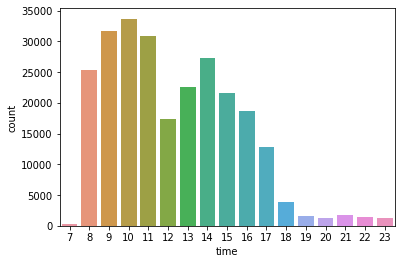

In [18]:
#Общий график активности 
sns.countplot(x=A_time.index) 


<AxesSubplot:xlabel='time', ylabel='count'>

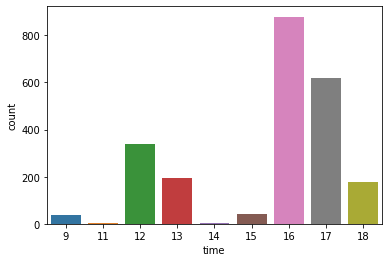

In [19]:
Only_Alic = A_time.query('Alice==1')
sns.countplot(x = Only_Alic.index)

In [20]:
#Поиск месяцев Элис
A_start_mounth= pd.DataFrame({'month': train_df.time1.apply(lambda x: x[5:7]).astype(int), 'Alice': train_df.target}).set_index('month')

<AxesSubplot:xlabel='month', ylabel='count'>

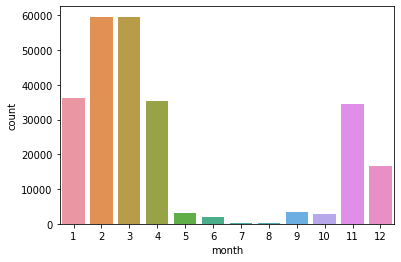

In [21]:
#Общий график активности по месяцам, у кого в какой месяц началаст первая сессия
sns.countplot(x=A_start_mounth.index) 

<AxesSubplot:xlabel='month', ylabel='count'>

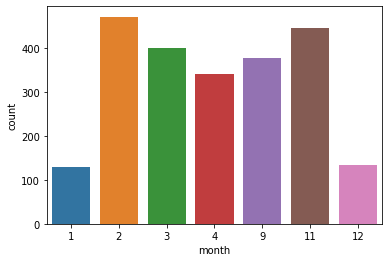

In [22]:
Only_Alic2 = A_start_mounth.query('Alice==1')
sns.countplot(x = Only_Alic2.index)

<AxesSubplot:xlabel='count_steps', ylabel='count'>

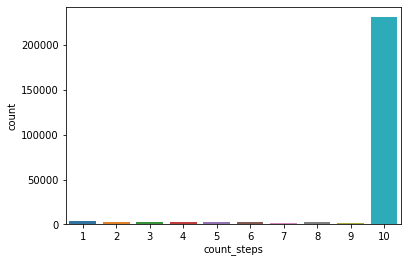

In [23]:
#Поиск сколько шагов сделала элис
time = ['time%s' % i for i in range(1,11)]
A_count_step = train_df.drop(time, axis=1)
A_count_step = A_count_step.drop('target', axis=1)
A_count_step=A_count_step.fillna(0)
A_count_step['count_steps'] = 10-(A_count_step == 0).astype(int).sum(axis=1)
A_count_step['Alice'] = train_df.target
A_count_step_finall = A_count_step[['count_steps', 'Alice']].set_index('count_steps')
sns.countplot(x=A_count_step_finall.index)

In [24]:
Only_Alic3 = A_count_step_finall.query('Alice==1')
Only_Alic3.value_counts()
# sns.countplot(x = Only_Alic3.index)

Alice
1        2297
dtype: int64

In [25]:
#Количество уникальных сайтов которые посещает элис за сессиию 
time = ['time%s' % i for i in range(1,11)]
DFforUniqSItes = train_df.drop(time, axis=1)
DFforUniqSItes = DFforUniqSItes.drop('target', axis=1)
UniqSitesPerSes = pd.DataFrame({'num_uniq_sites': DFforUniqSItes.apply(pd.Series.nunique, axis=1)})

In [26]:
UniqSitesPerSes['Alice'] = train_df.target
UniqSitesPerSes = UniqSitesPerSes.set_index('num_uniq_sites')

<AxesSubplot:xlabel='num_uniq_sites', ylabel='count'>

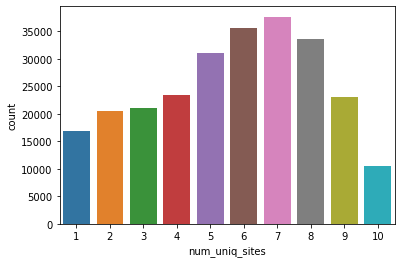

In [27]:
sns.countplot(x=UniqSitesPerSes.index) 

<AxesSubplot:xlabel='num_uniq_sites', ylabel='count'>

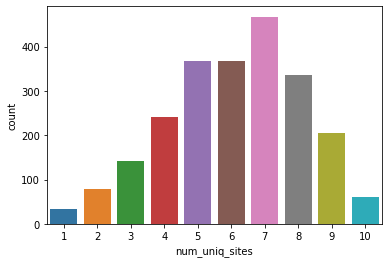

In [28]:
Only_Alic4 = UniqSitesPerSes.query('Alice==1')
sns.countplot(x = Only_Alic4.index)

In [29]:
# Поиск паттернов поведения Элис 
time = ['time%s' % i for i in range(1,11)]
AlicesLoveSites = train_df.drop(time, axis=1)
AlicesLoveSites = AlicesLoveSites.query('target == 1')
AlicesLoveSites =  AlicesLoveSites.drop('target', axis=1)
AlicesLoveSites

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
153,5397,5395.0,22.0,5396.0,5402.0,5392.0,22.0,35.0,33.0,338.0
287,10941,9783.0,9786.0,27339.0,27338.0,29.0,27339.0,9783.0,9785.0,10941.0
430,37,270.0,32.0,33.0,35.0,704.0,29.0,33.0,12623.0,704.0
644,39,23.0,677.0,22.0,39.0,23.0,21.0,678.0,22.0,678.0
682,77,879.0,80.0,879.0,80.0,879.0,77.0,879.0,879.0,80.0
...,...,...,...,...,...,...,...,...,...,...
252790,80,879.0,879.0,879.0,80.0,80.0,76.0,80.0,80.0,80.0
252850,2271,37.0,17283.0,29.0,29.0,30.0,17283.0,143.0,33.0,18876.0
253140,4694,27332.0,2409.0,27332.0,2401.0,27332.0,27332.0,4696.0,27332.0,2401.0


In [30]:
AlicesLoveSites['MostPopSiteperSes'] = pd.DataFrame({'a': AlicesLoveSites.mode(axis=1)[0]})
# lovasite = pd.DataFrame({'love_unique_sites': AlicesLoveSites.MostPopSiteperSes.unique()})
# lovasite
AlicesLoveSites.MostPopSiteperSes.value_counts().head(30)


76.0       205
77.0       170
21.0       168
29.0       129
80.0       103
75.0        65
81.0        62
22.0        62
879.0       55
23.0        52
3000.0      50
82.0        47
881.0       43
7832.0      35
855.0       34
3.0         34
733.0       33
2078.0      32
941.0       31
37.0        24
30.0        23
12619.0     21
1514.0      20
3559.0      18
616.0       17
704.0       17
52.0        16
27307.0     14
2077.0      14
335.0       14
Name: MostPopSiteperSes, dtype: int64

In [146]:
#общее время в сети для элис 
AliceTime = pd.DataFrame({'FullTime': DF_Full2Time[:253561].delta.astype(str).apply(lambda x: x[10:]).apply(lambda x: x.replace(":","")), 'Alice': train_df.target})

In [152]:
NotAlic5 = AliceTime.query('Alice==0')
NotAlic5.FullTime.value_counts().head(10)

0002    14380
0001    10750
0003    10273
0004     7960
0000     6692
0005     6533
0006     5696
0009     5294
0007     5057
0008     4649
Name: FullTime, dtype: int64

In [1070]:
Only_Alic5 = AliceTime.query('Alice==1')
Only_Alic5.FullTime.value_counts().head(30)

0003    186
0004    166
0002    144
0005    112
0006    101
0008     81
0007     80
0009     79
0001     76
0010     57
0011     54
0012     41
0013     41
0016     40
0014     38
0015     34
0018     31
0020     24
0023     24
0017     24
0021     22
0026     21
0033     21
0019     20
0022     20
0000     19
0029     17
0025     17
0032     16
0043     16
Name: FullTime, dtype: int64

In [1184]:
#ФСоздание новых фич
time = ['time%s' % i for i in range(1,11)]
DF_Full1 = DF_Full.drop(time, axis=1)

In [1185]:
#Способ1 Лучшая
# DF_Full1=DF_Full1.fillna(0)
DF_Full1.site1 = DF_Full1.site1.astype(float)

#Число уникальных сайтов в сессии
# DF_Full1['num_uniq_sites'] = DF_Full1.apply(pd.Series.nunique, axis=1)
# DF_Full1['num_uniq_sites'] = DF_Full1['num_uniq_sites'].apply(lambda x: 1 if x==7 else 0)

#Фича времени посещения первого сайта до полудня или после
DF_Full1['1stEntryMorning'] = DF_Full.time1.apply(lambda x: x[11:13]).astype(int).apply(lambda x: 1 if  x==12 or x==13  or x==16 or x==17 or x==18  else 0)

#Число шагов в сессии (Число сайтов - число нулей )
DF_Full1=DF_Full1.fillna(1111)
DF_Full1['count_steps'] = 10-(DF_Full1 == 1111).astype(int).sum(axis=1)
DF_Full1['count_steps'] = DF_Full1['count_steps'].apply(lambda x: 1 if x==10 else 0)


#Длина сессии в минутах 
# DF_Full1['SessionLength'] = DF_Full2Time.delta.astype(str).apply(lambda x: x[10:]).apply(lambda x: x.replace(":","")).astype(int)


#Масштабирование признака по первому моесещению 
DF_Full1['day1'] = DF_Full.time1.apply(lambda x: x[:7].replace('-', '0')).astype(int).apply(lambda x: x/2.013710e+06)
# DF_Full1['day2'] = DF_Full.time2 #.apply(lambda x: x[:7].replace('-', '0')).astype(int).apply(lambda x: x/2.013710e+06)
# DF_Full1['day3'] = DF_Full.time3
# DF_Full1['day4'] = DF_Full.time4 #дальше падает rocauc
# DF_Full1['day5'] = DF_Full.time5
# DF_Full1['day6'] = DF_Full.time6
# DF_Full1['day7'] = DF_Full.time7
# DF_Full1['day8'] = DF_Full.time8
# DF_Full1['day9'] = DF_Full.time9
# DF_Full1['day10'] = DF_Full.time10

#Месяц в который началась сессия
DF_Full1['MonthStarting'] = DF_Full.time1.apply(lambda x: x[5:7]).astype(int).apply(lambda x: 1 if x==2 or x==3 or x==4 or x==9 or x==11  else 0)

# Замена сайтов которыми пользуется Элис на одинаковые числа 
DF_Full1 = DF_Full1.replace({
76.0 :1,
77.0:1})
# 21.0:1
# 29.0:1,
# 80.0:1,
# # 75.0 :1,
# # 81.0 :1,
# # 22.0 :1,
# # 879.0:1,
# # 23.0 :1,
# # 3000.0 :1,
# # 82.0:1,
# # 881.0:1
# # })


#Для метода Dummies нужно сделать цифры строками 
# DF_Full1.site1 = DF_Full1.site1.astype(str)
# DF_Full1.site2 = DF_Full1.site2.astype(str)

#Удаление лишних столбцов
# DF_Full1 = DF_Full1.drop(['site4', 'site5'], axis=1)

#если надо когда убираем признак count_steps
#DF_Full1=DF_Full1.fillna(0)




In [1163]:
#Способ 2
# DF_Full1=DF_Full1.fillna(0)
DF_Full1.site1 = DF_Full1.site1.astype(float)

#Число уникальных сайтов в сессии
DF_Full1['num_uniq_sites'] = DF_Full1.apply(pd.Series.nunique, axis=1)
DF_Full1['num_uniq_sites'] = DF_Full1['num_uniq_sites'].apply(lambda x: 1 if x==7 else 0)

#Фича времени посещения первого сайта до полудня или после
DF_Full1['1stEntryMorning'] = DF_Full.time1.apply(lambda x: x[11:13]).astype(int).apply(lambda x: 1 if  x==12 or x==13  or x==16 or x==17 or x==18  else 0)

#Число шагов в сессии (Число сайтов - число нулей )
DF_Full1=DF_Full1.fillna(1111)
DF_Full1['count_steps'] = 10-(DF_Full1 == 1111).astype(int).sum(axis=1)
DF_Full1['count_steps'] = DF_Full1['count_steps'].apply(lambda x: 1 if x==10 else 0)


#Длина сессии в минутах 
DF_Full1['SessionLength'] = DF_Full2Time.delta.astype(str).apply(lambda x: x[10:]).apply(lambda x: x.replace(":","")).astype(int)


#Масштабирование признака по первому моесещению 
DF_Full1['day1'] = DF_Full.time1.apply(lambda x: x[:7].replace('-', '0')).astype(int).apply(lambda x: x/2.013710e+06)
DF_Full1['day2'] = DF_Full.time2 #.apply(lambda x: x[:7].replace('-', '0')).astype(int).apply(lambda x: x/2.013710e+06)
DF_Full1['day3'] = DF_Full.time3
DF_Full1['day4'] = DF_Full.time4 #дальше падает rocauc
# DF_Full1['day5'] = DF_Full.time5
# DF_Full1['day6'] = DF_Full.time6
# DF_Full1['day7'] = DF_Full.time7
# DF_Full1['day8'] = DF_Full.time8
# DF_Full1['day9'] = DF_Full.time9
# DF_Full1['day10'] = DF_Full.time10

#Месяц в который началась сессия
DF_Full1['MonthStarting'] = DF_Full.time1.apply(lambda x: x[5:7]).astype(int).apply(lambda x: 1 if x==2 or x==3 or x==4 or x==9 or x==11  else 0)

# Замена сайтов которыми пользуется Элис на одинаковые числа 
DF_Full1 = DF_Full1.replace({
76.0 :1,
77.0:1,
21.0:1,
29.0:1,
80.0:1,
75.0 :1,
81.0 :1,
22.0 :1,
879.0:1,
23.0 :1,
3000.0 :1,
82.0:1,
881.0:1
})


#Для метода Dummies нужно сделать цифры строками 
# DF_Full1.site1 = DF_Full1.site1.astype(str)
# DF_Full1.site2 = DF_Full1.site2.astype(str)

#Удаление лишних столбцов
# DF_Full1 = DF_Full1.drop(['site4', 'site5'], axis=1)

#если надо когда убираем признак count_steps
#DF_Full1=DF_Full1.fillna(0)



In [1186]:
DF_Full1

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,1stEntryMorning,count_steps,day1,MonthStarting
session_id,,,,,,,,,,,,,,
1,718.0,1111.0,1111.0,1111.0,1111.0,1111.0,1111.0,1111.0,1111.0,1111.0,0,0,1.000145,1
2,890.0,941.0,3847.0,941.0,942.0,3846.0,3847.0,3846.0,1516.0,1518.0,0,1,1.000145,1
3,14769.0,39.0,14768.0,14769.0,37.0,39.0,14768.0,14768.0,14768.0,14768.0,1,1,0.999653,0
4,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,782.0,0,1,1.000146,1
5,22.0,177.0,175.0,178.0,177.0,178.0,175.0,177.0,177.0,178.0,0,1,1.000145,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82793,812.0,1039.0,676.0,1111.0,1111.0,1111.0,1111.0,1111.0,1111.0,1111.0,1,0,1.000149,0
82794,300.0,302.0,302.0,300.0,300.0,1222.0,302.0,1218.0,1221.0,1216.0,0,1,1.000146,0
82795,29.0,33.0,35.0,22.0,37.0,6779.0,30.0,21.0,23.0,6780.0,0,1,1.000146,0


In [1133]:
# DF_Full1.SessionLength.nunique() строчка для всякого

In [1187]:
DF_Full1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336358 entries, 1 to 82797
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   site1            336358 non-null  float64
 1   site2            336358 non-null  float64
 2   site3            336358 non-null  float64
 3   site4            336358 non-null  float64
 4   site5            336358 non-null  float64
 5   site6            336358 non-null  float64
 6   site7            336358 non-null  float64
 7   site8            336358 non-null  float64
 8   site9            336358 non-null  float64
 9   site10           336358 non-null  float64
 10  1stEntryMorning  336358 non-null  int64  
 11  count_steps      336358 non-null  int64  
 12  day1             336358 non-null  float64
 13  MonthStarting    336358 non-null  int64  
dtypes: float64(11), int64(3)
memory usage: 46.6 MB


In [1165]:
# ONEHOTENCODER 
DF_Full1 = preprocessing.OneHotEncoder().fit_transform(DF_Full1)

In [1166]:
DF_Full1

<336358x1102036 sparse matrix of type '<class 'numpy.float64'>'
	with 6390802 stored elements in Compressed Sparse Row format>

In [1136]:
# CSR MATRIX

In [1188]:
DF_Full_1part = DF_Full1[['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10']].values.flatten()

In [1189]:
DF_Full_1part = csr_matrix( ([1] * DF_Full_1part.shape[0],
                                DF_Full_1part,
                                range(0, DF_Full_1part.shape[0] + 10, 10))) [:, 1:]

In [1190]:
DF_Full_1part

<336358x48371 sparse matrix of type '<class 'numpy.intc'>'
	with 3363580 stored elements in Compressed Sparse Row format>

In [1191]:
DF_Full1 = csr_matrix(hstack([DF_Full_1part, DF_Full1[['1stEntryMorning', 'MonthStarting', 'count_steps','day1']]]))

In [1192]:
DF_Full1

<336358x48375 sparse matrix of type '<class 'numpy.float64'>'
	with 2836859 stored elements in Compressed Sparse Row format>

In [1193]:
#336358x1102049

In [1194]:
# CSR Matrix 336358x48371

In [1195]:
#Отсоединение измененной Обучающей выборки от измененной целой и обучение моделей 

In [1214]:
X = DF_Full1[:253561]
X

<253561x48375 sparse matrix of type '<class 'numpy.float64'>'
	with 2197005 stored elements in Compressed Sparse Row format>

In [1215]:
y = train_df.target

In [1216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=17)

In [1217]:
# МОДЕЛИ:

In [1218]:
#Логистическая регрессия


In [1219]:
Logistic1 = LogisticRegression(C=1, n_jobs=-1, random_state=17)
Logistic2 = LogisticRegression(C=1, random_state=17, solver='lbfgs', n_jobs=-1, class_weight='balanced')

In [1220]:
c_values = np.logspace(-2, 2, 20)
Logistic3 = LogisticRegression(random_state=17)
logit_grid_searcher = GridSearchCV(Logistic3, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=3, verbose=1)
# logit_grid_searcher.fit(X_train, y_train)
# roc_auc_score(y_test, logit_grid_searcher.predict_proba(X_test)[:, 1])

In [1221]:
#Стохастические Гр Бустинг

In [1222]:
sgd1 = SGDClassifier(loss='log', random_state=17, n_jobs=-1, alpha=5e-06, max_iter=500)

In [1223]:
#Рандомный лес 

In [1224]:
Forest1 = RandomForestClassifier(random_state=17, n_jobs=-1)
params = {'n_estimators': range(100, 150, 10),
                 'max_depth': range(4,10 ,2), 
                 'min_samples_leaf': range(1, 8)}
            
RFgridsearch1 = RandomizedSearchCV(Forest1, params, cv=5, n_jobs=-1, scoring='roc_auc')


In [1225]:
def Modelauc (model1, model2, X_train, X_test, y_train, y_test):
    pok = []
    model_list = [model1, model2]
    for model in model_list:
        model.fit(X_train, y_train)
       
        a = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]);
        b = precision_score(y_test, model.predict(X_test));
        c = recall_score(y_test, model.predict(X_test));

        pok.append(model.predict_proba(X_test)[:, 1]);

        print('For model', str(model)[0:11], 'ROC_AUC=', a)
        print('For model', str(model)[0:11], 'Prec=', b)
        print('For model', str(model)[0:11], 'Recall=', c)
        print('____________________________________________________')

    # return(pok)

    tablet = pd.DataFrame({'aa':pok[0], 'ab': pok[1]})
    tablet['Res'] = (tablet.aa + tablet.ab)/2
    print(tablet)
    print('Значение ROC-AUC для среднего по моделям')
    print(roc_auc_score(y_test, tablet['Res']))

   

In [1226]:
Modelauc(Logistic1, Forest1, X_train, X_test, y_train, y_test)

For model LogisticReg ROC_AUC= 0.9843152546429101
For model LogisticReg Prec= 0.8106796116504854
For model LogisticReg Recall= 0.25037481259370314
____________________________________________________
For model RandomFores ROC_AUC= 0.9789124893270721
For model RandomFores Prec= 0.8803088803088803
For model RandomFores Recall= 0.34182908545727136
____________________________________________________
                 aa    ab           Res
0      5.520731e-05  0.00  2.760366e-05
1      7.156151e-03  0.00  3.578076e-03
2      5.567867e-04  0.00  2.783934e-04
3      1.094278e-05  0.00  5.471390e-06
4      1.387241e-06  0.00  6.936207e-07
...             ...   ...           ...
76064  6.237810e-06  0.00  3.118905e-06
76065  7.039477e-07  0.00  3.519739e-07
76066  4.829477e-05  0.01  5.024147e-03
76067  1.340775e-03  0.01  5.670388e-03
76068  5.564209e-04  0.00  2.782105e-04

[76069 rows x 3 columns]
Значение ROC-AUC для среднего по моделям
0.9906755860551463


In [821]:
# train = 0.8 0.9933
# train = 0.7 0.9906

Init signature:
RandomizedSearchCV(
    estimator,
    param_distributions,
    *,
    n_iter=10,
    scoring=None,
    n_jobs=None,
    refit=True,
    cv=None,
    verbose=0,
    pre_dispatch='2*n_jobs',
    random_state=None,
    error_score=nan,
    return_train_score=False,
)
Docstring:     
Randomized search on hyper parameters.

RandomizedSearchCV implements a "fit" and a "score" method.
It also implements "score_samples", "predict", "predict_proba",
"decision_function", "transform" and "inverse_transform" if they are
implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized
by cross-validated search over parameter settings.

In contrast to GridSearchCV, not all parameter values are tried out, but
rather a fixed number of parameter settings is sampled from the specified
distributions. The number of parameter settings that are tried is
given by n_iter.

If all parameters are presented as a list,
sampling without replacement is p

In [51]:
#Отсоединение измененной тестовой выборки от измененной целой

In [1211]:
Finial_Test = DF_Full1[253561:]
Finial_Test

<82797x48375 sparse matrix of type '<class 'numpy.float64'>'
	with 639854 stored elements in Compressed Sparse Row format>

In [1212]:
def Result (model1, model2, X_test):
    pok = []
    model_list = [model1, model2]
    for model in model_list:
        model.fit(X, train_df.target)
        
        
        # a = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]);
        # b = precision_score(y_test, model.predict(X_test));
        # c = recall_score(y_test, model.predict(X_test));

        pok.append(model.predict_proba(X_test)[:, 1]);

     
    # return(pok)

    tablet = pd.DataFrame({'aa':pok[0], 'ab': pok[1]})
    tablet['Res'] = (tablet.aa + tablet.ab)/2
    print(tablet)
    print('____________________________________________________')
    print('                                                    ')

    pd.DataFrame({'session_id': range(1, 82798), 'target': tablet.Res}).set_index('session_id').to_csv('Model3_Catch_Alice.csv')

In [1213]:
Result(Logistic1, Forest1, Finial_Test)

                 aa   ab           Res
0      4.136467e-05  0.0  2.068234e-05
1      2.461512e-08  0.0  1.230756e-08
2      1.478836e-10  0.0  7.394178e-11
3      1.512711e-09  0.0  7.563556e-10
4      2.357803e-07  0.0  1.178901e-07
...             ...  ...           ...
82792  4.074616e-05  0.0  2.037308e-05
82793  5.135570e-08  0.0  2.567785e-08
82794  1.414839e-04  0.0  7.074193e-05
82795  5.277454e-06  0.0  2.638727e-06
82796  7.209848e-07  0.0  3.604924e-07

[82797 rows x 3 columns]
____________________________________________________
                                                    


In [1181]:
Logistic4 = LogisticRegression(C=1, n_jobs=-1, random_state=17)
pd.DataFrame({'session_id': range(1, 82798), 'target': Logistic4.fit(X, train_df.target).predict_proba(Finial_Test)[:, 1]}).set_index('session_id').to_csv('Model1_Catch_Alice.csv')